<a href="https://colab.research.google.com/github/raudh1/LorenzModel/blob/main/GenTrajMLPLorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from random import randint
import os
import sys
import string
#from torch import Dataset, Dataloader
from numpy import linalg as LA
from torchsummary import summary
from numpy.core.defchararray import asarray
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import AnchoredText
from sklearn.model_selection import train_test_split

In [2]:
from torch.autograd import grad
import pandas as pd


In [3]:
from matplotlib import pyplot as plt

In [4]:
import torch.nn.functional as F


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set files and directories

In [187]:
torch.set_default_tensor_type('torch.DoubleTensor')
mypath="./drive/MyDrive/exp/"

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')

print("device=",device)

device= cpu


In [349]:
#DEFINE MLP
class Model(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 60, bias=True)
        self.lin2 = nn.Linear(60, 42, bias=True)
        self.lin3 = nn.Linear(42, 3, bias=True)

    def forward(self, xb):
        x = xb.contiguous().view(-1, 3)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)

        return self.lin3(x).view(-1,1,3)              # if you use 9 traj instead of 1 use 9 

    def predict(self,input,N):
      
      output=torch.zeros(N+input.shape[0],1,3)
      traj_pred= self.forward(input)

      
      output[:len(traj_pred)]=traj_pred
      inp=traj_pred[-1]

      for i in range(len(traj_pred),N+len(traj_pred)):
        inp=self.forward(inp)
        output[i]=inp

      return output

    

In [350]:
if __name__ == '__main__':

    # load data and make training set
    hidden   = 32
    layer    = 2
    features = 3
    dropout  = 0
    # build the model        
    ini = 25
case = 'FULL'


In [403]:
def load_data(case,sampling=5,start=0):

  if (case=='MANI'or case=='PART' ):

    name=mypath+'/'+case+'_'+str(k)+'.npy'
    data = np.load(name).astype('float64')
    data=np.moveaxis(data,-1,0)
    data=data[::sampling,:1,:]                    # one of 9 trajectories and sampling
    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8
    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data

  elif (case=='other'):
    name= mypath+'/other_traj.npy'
    data = np.load(name).astype('float64')
    data=np.moveaxis(data,-1,0)
    data=data[::sampling,:1,:]

    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8

    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data
     
  elif (case=='zero'):
    name=mypath+'/zeros_traj.npy'
    data = np.load(name).astype('float64')

    data=np.moveaxis(data,-1,0)
    data=data[::sampling,:1,:]

    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8

    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data

  elif (case=='FULL'):
    name=mypath+'/'+case+'_'+str(k)+'.npy'
    data = np.load(name).astype('float64')
    data = np.expand_dims(data.T, axis=1)
    data=data[::sampling,:1,:]

    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8

    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data

**TRAIN**

In [446]:
k=0

train_data, valid_data, test_data=load_data(case,2)
print(train_data.shape)


seq = Model().double().to(device)

def train(model,train_data,valid_data,lr=1e-3,epoch=50):

      print('input shape=',train_data.shape," target shape =",valid_data.shape)
      criterion = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr) #learning rate fixed#
  
  
      err = 10
      loss1 = 1
      i = 0
      valid_loss=[]
      loss_grad=[]
      train_loss= []
      i=0
      np.random.randint(0,train_data.shape[0])
      min_perf = 90000
      while i<epoch: 
          model.train()
          optimizer.zero_grad()
          #j = np.random.randint(0,train_data.shape[0]-1)
          #out =model(train_data[j].unsqueeze(0))  #INPUT
          out =model(train_data[:-1])
          #loss = criterion(out, train_data[j+1].unsqueeze(0)) # OUTPUT
          loss = criterion(out, train_data[1:]) # OUTPUT
          loss.backward()

          train_loss.append(loss.item())

          optimizer.step()
          # validation
          with torch.no_grad():
            model.eval()
            pred = model(valid_data[:-1])
            #k = np.random.randint(0,valid_data.shape[0]-1)

            #pred = model(valid_data[k].unsqueeze(0))

            validloss = criterion(pred, valid_data[1:])
            valid_loss.append(validloss.item())
     
          if i%(50)==0:
              loss2 = loss
              err = np.abs(loss2.item()-loss1)/10
              loss1 = loss2.item()
              print(i, "train loss", train_loss[-1], "valid loss",
                  valid_loss[-1])
          i += 1
          sys.stdout.flush()
          if validloss.item() < min_perf :
            min_perf = validloss.item()
            torch.save(model.state_dict(), './param')
      
      print("last epoch: ", i)
      

      return train_loss, valid_loss

torch.Size([10125, 1, 3])


In [448]:
t_loss,v_loss=train(seq,train_data, valid_data,lr=0.001,epoch=50000)

input shape= torch.Size([10125, 1, 3])  target shape = torch.Size([1687, 1, 3])
0 train loss 0.01048003520118187 valid loss 0.5970972549943607
50 train loss 0.010411128096771851 valid loss 0.009073300886621973
100 train loss 0.010168306943465192 valid loss 0.008229092859682314
150 train loss 0.010008254584699863 valid loss 0.008053047612835854
200 train loss 0.009836171086408642 valid loss 0.007907427236285338
250 train loss 0.009640658105613879 valid loss 0.007739045410046438
300 train loss 0.009438592744823794 valid loss 0.00755934899665761
350 train loss 0.009220104535161543 valid loss 0.0073574771090785225
400 train loss 0.00899668395563087 valid loss 0.007171390245434625
450 train loss 0.008768776520400768 valid loss 0.006976839508049083
500 train loss 0.008541750754368195 valid loss 0.006787059453367376
550 train loss 0.00832435958261189 valid loss 0.006611211396145088
600 train loss 0.008549139091388833 valid loss 0.006497306395401775
650 train loss 0.00793139291818086 valid los

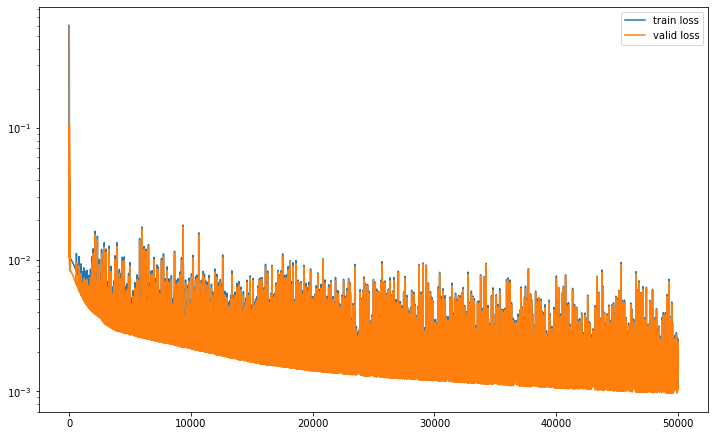

In [449]:
plt.figure(figsize=(12,7.45))

plt.plot(t_loss[:],label='train loss')
plt.plot(v_loss[:],label='valid loss')
#plt.xlim(len(t_loss)-100,len(t_loss))
plt.semilogy()
plt.legend()
plt.show()


In [408]:
def generate(model,input,history,future):

  return model.predict(input[:history],N=future)

In [450]:
mdl = Model()
mdl.load_state_dict(torch.load('./param'))

<All keys matched successfully>

In [454]:
input = test_data
input.shape

torch.Size([1687, 1, 3])

In [455]:
history=100
future=500
traj=generate(seq,input,history,future).detach().numpy()
traj_1step=seq(input[:(history+future)]).detach().numpy()

**PLOT**

In [440]:
def plot_traj(history,traj_1step,traj,coordinate='x',data=False):
  if coordinate=='x':
    i=0
  if coordinate=='y':
    i=1
  if coordinate=='z':
    i=2

  plt.figure(figsize=(14.4,8.8))
  plt.plot(traj_1step[:,0,i],label='1step model')
  plt.plot(traj[:,0,i],label='traj_generate')
  if data is True:
    plt.plot(input[:,0,i],label='real data')

  plt.scatter(history,seq(input)[history,0,i].detach().numpy(),color='red')

  plt.xlim(history-100,len(traj))
  plt.ylabel(rf'${coordinate}(t)$',fontsize=20)
  plt.xlabel(r'$t$',fontsize=20)
  plt.legend()
  plt.show()
  print(traj_1step.shape, traj.shape)
  print(np.linalg.norm(traj_1step-traj))

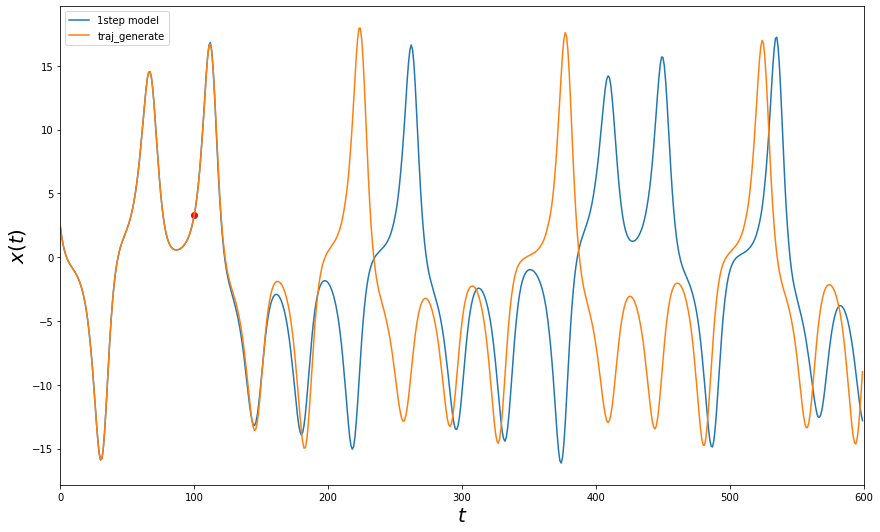

(600, 1, 3) (600, 1, 3)
403.2528191721856


In [456]:
plot_traj(history,traj_1step=traj_1step,traj=traj,coordinate='x',data=False)

In [214]:
print(len(traj),len(traj_1step))

1500 1500


In [507]:
def plot_3D(traj,traj_1step,history=history,length=future):
  fig = plt.figure(figsize=(20,15))
  ax = fig.gca(projection="3d")
  start=history

  #ax.plot(traj_1step[start:history+length,0,0],traj_1step[start:history+length,0,1],traj_1step[start:history+length,0,2],label='1 step traj',linestyle='--')
  ax.plot(traj[start:history+length,0,0],traj[start:history+length,0,1],traj[start:history+length,0,2],label='generated traj')
  ax.plot(input[start:history+length,0,0],input[start:history+length,0,1],input[start:history+length,0,2],label='real traj')

  
  ax.scatter3D(traj[history,0,0],traj[history,0,1],traj[history,0,2],c='green',label='starting point')
  ax.set_xlabel(r'$x$',fontsize=30)
  ax.set_ylabel(r'$y$',fontsize=30)
  ax.set_zlabel(r'$z$',fontsize=30)

  ax.legend(fontsize=15)

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


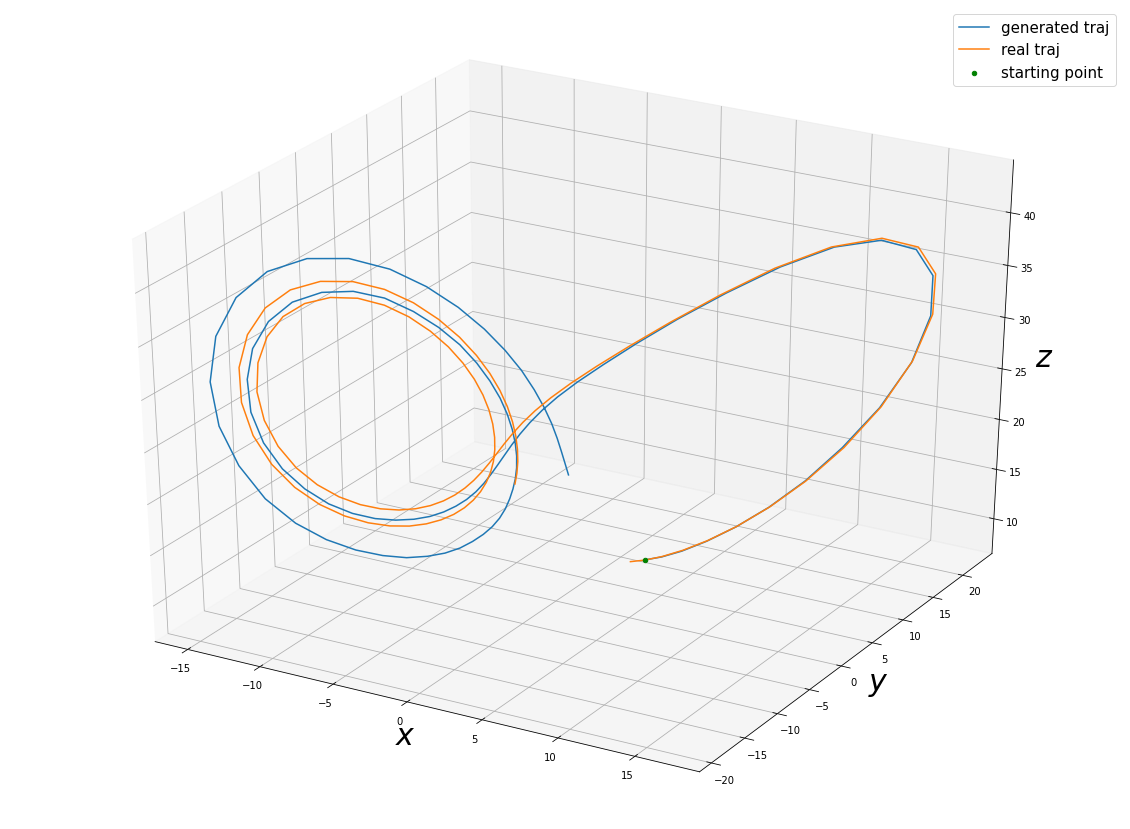

In [508]:
plot_3D(traj,traj_1step,history=history,length=100)